In [22]:
import cv2
import os

import tqdm
from dnn_face_detection import detect_face 



In [23]:

video_path = "dataset/video"
destination =  "dataset/images"

In [24]:

#For randomly increasing dataset and balancing datasets
import numpy as np
def rand():
    return np.random.binomial(n=1,p=0.2,size=[1])

def random_num(i):
    return int(np.random.randint(0,i))

In [25]:
for root, files, videos in tqdm.tqdm(os.walk(video_path)):
    for video in videos:
        video_id = root.split("\\")[-1]
        destination_path = os.path.join(destination, video_id)
        if not os.path.isdir(destination_path):
            os.mkdir(destination_path)
        cap = cv2.VideoCapture(os.path.join(root, video))
       
        #For balancing images
        balance=[]
        balance_count=0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.flip(frame,1)
            faces = detect_face(frame)
            for bbounding_box in faces:
                x = int(bbounding_box[0])
                y = int(bbounding_box[1])
                x2 = int(bbounding_box[2])
                y2 = int(bbounding_box[3])

                crop_face = frame[y:y2, x:x2]
                crop_face = cv2.resize(crop_face, (160,160))
                balance.append(crop_face)
                cv2.imwrite(f"{destination_path}/{balance_count}.png",crop_face)
                
            balance_count += 1
       
        
        #For balancing our data set
        while balance_count<1000:
                if rand():
                    index=random_num(len(balance))
                    balance_count+=1
                    cv2.imwrite(f"{destination_path}/{balance_count}.png",balance[index])
        
                

8it [02:08, 16.10s/it]


## Training

In [26]:
import numpy as np
import cv2
import random
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.models import Sequential
from keras_facenet import FaceNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [27]:
train_dir = "dataset/images/"
batch_size =32 
img_width, img_height = 160,160
epochs = 10

In [28]:
seed = np.random.seed(123)

In [29]:
data_generator = ImageDataGenerator(
                    rotation_range=15,
                    horizontal_flip= True,
                    validation_split = 0.2,
                        brightness_range=(0.4,1),
                    rescale = 1./255)


train_data = data_generator.flow_from_directory(
        directory=train_dir,
        batch_size = batch_size,
        class_mode = 'categorical',
        target_size = (img_width, img_height),
        subset= "training",
                        seed = seed,

        # shuffle= True
)

test_data = data_generator.flow_from_directory(
      directory= train_dir,
        batch_size = batch_size,
        class_mode = 'categorical',
        target_size = (img_width, img_height),
                        seed = seed,

        subset= "validation"
)

Found 5527 images belonging to 7 classes.
Found 1380 images belonging to 7 classes.


In [30]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 7, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

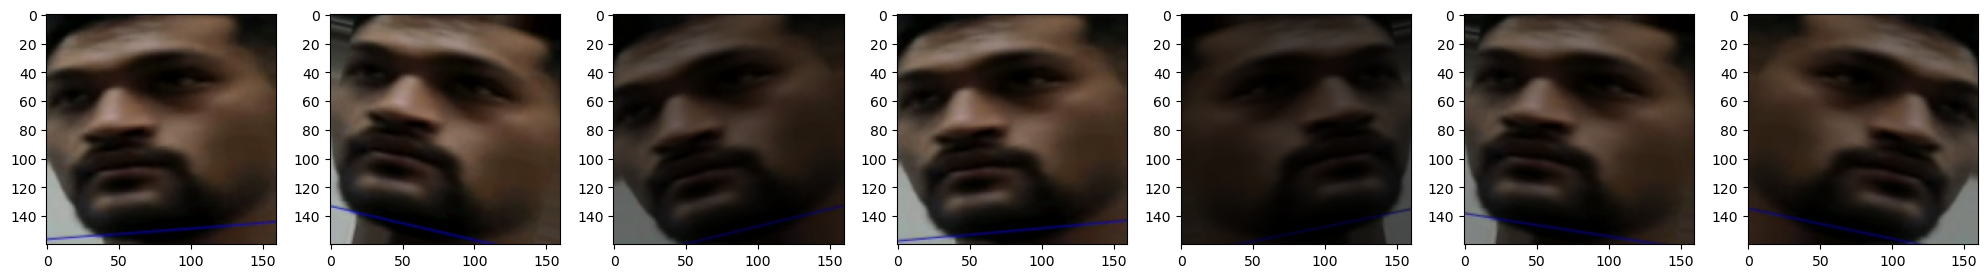

In [31]:
for j in range(7):
    pre_processed_img = [train_data[0][0][j] for i in range(7)]
plotImages(pre_processed_img)

In [32]:
embeder = FaceNet()

In [33]:
facenet_model = embeder.model

In [34]:
print(facenet_model.summary())

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, None, None,   96         ['Conv2d_1a_3x3[0][0]']          
 Normalization)                 32)                                             

In [35]:
for i in range(len(facenet_model.layers)):
    print(facenet_model.layers[i].name)

input_2
Conv2d_1a_3x3
Conv2d_1a_3x3_BatchNorm
Conv2d_1a_3x3_Activation
Conv2d_2a_3x3
Conv2d_2a_3x3_BatchNorm
Conv2d_2a_3x3_Activation
Conv2d_2b_3x3
Conv2d_2b_3x3_BatchNorm
Conv2d_2b_3x3_Activation
MaxPool_3a_3x3
Conv2d_3b_1x1
Conv2d_3b_1x1_BatchNorm
Conv2d_3b_1x1_Activation
Conv2d_4a_3x3
Conv2d_4a_3x3_BatchNorm
Conv2d_4a_3x3_Activation
Conv2d_4b_3x3
Conv2d_4b_3x3_BatchNorm
Conv2d_4b_3x3_Activation
Block35_1_Branch_2_Conv2d_0a_1x1
Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm
Block35_1_Branch_2_Conv2d_0a_1x1_Activation
Block35_1_Branch_1_Conv2d_0a_1x1
Block35_1_Branch_2_Conv2d_0b_3x3
Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm
Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm
Block35_1_Branch_1_Conv2d_0a_1x1_Activation
Block35_1_Branch_2_Conv2d_0b_3x3_Activation
Block35_1_Branch_0_Conv2d_1x1
Block35_1_Branch_1_Conv2d_0b_3x3
Block35_1_Branch_2_Conv2d_0c_3x3
Block35_1_Branch_0_Conv2d_1x1_BatchNorm
Block35_1_Branch_1_Conv2d_0b_3x3_BatchNorm
Block35_1_Branch_2_Conv2d_0c_3x3_BatchNorm
Block35_1_Branch_

In [36]:
model = Sequential()

In [37]:
facenet_model.trainable = False
model.add(facenet_model)

In [59]:
train_data.num_classes
train_data.class_indices

{'badal': 0,
 'bibek': 1,
 'mukesh': 2,
 'nasla': 3,
 'prapti': 4,
 'sujen': 5,
 'swastika': 6}

In [39]:
# model.add(Dense(512, activation="relu"))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(train_data.num_classes, activation="softmax"))

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v1 (Functi  (None, 512)              23497424  
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 23,501,015
Trainable params: 3,591
Non-trainable params: 23,497,424
_________________________________________________________________


In [41]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01), loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [20]:
early_stoping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                patience=3,
                                                restore_best_weights= True,
                                                    )

In [42]:
training = model.fit_generator(train_data, validation_data=test_data, 
                               steps_per_epoch=train_data.samples // batch_size, epochs=10,    
                               callbacks= [early_stoping]                         
                              )

C:\Users\Ghost\AppData\Local\Temp\ipykernel_12336\2051668556.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training = model.fit_generator(train_data, validation_data=test_data,


Epoch 1/10
172/172 [==============================] - 247s 1s/step - loss: 1.8589 - accuracy: 0.6273 - val_loss: 1.8014 - val_accuracy: 0.8428
Epoch 2/10
172/172 [==============================] - 74s 431ms/step - loss: 1.7457 - accuracy: 0.9414 - val_loss: 1.6894 - val_accuracy: 0.9841
Epoch 3/10
172/172 [==============================] - 74s 428ms/step - loss: 1.6398 - accuracy: 0.9873 - val_loss: 1.5868 - val_accuracy: 0.9884
Epoch 4/10
172/172 [==============================] - 72s 418ms/step - loss: 1.5403 - accuracy: 0.9891 - val_loss: 1.4899 - val_accuracy: 0.9899
Epoch 5/10
172/172 [==============================] - 72s 417ms/step - loss: 1.4458 - accuracy: 0.9938 - val_loss: 1.3989 - val_accuracy: 0.9935
Epoch 6/10
172/172 [==============================] - 71s 414ms/step - loss: 1.3585 - accuracy: 0.9938 - val_loss: 1.3145 - val_accuracy: 0.9949
Epoch 7/10
172/172 [==============================] - 75s 432ms/step - loss: 1.2771 - accuracy: 0.9936 - val_loss: 1.2382 - val_accu

In [46]:
classes = ['badal',
 'bibek',
 'mukesh',
 'nasla',
 'prapti',
 'sujen',
 'swastika']

In [61]:
for i in range(0,10):
    img = cv2.imread(f"dataset/images/bibek/{i}.png")
    try:
        img = np.expand_dims(img, axis=0)
        result =  model.predict(img,verbose=0)
        print(result)
        print(classes[np.argmax(result)])
    except:
        print("not indexed")

[[0.14529385 0.11254952 0.15969378 0.15086693 0.14721376 0.18142414
  0.10295807]]
sujen
[[0.14226508 0.11251448 0.15730049 0.15147975 0.14888668 0.18445486
  0.10309868]]
sujen
[[0.1447945  0.11223081 0.15886147 0.1508222  0.14657094 0.18213624
  0.1045839 ]]
sujen
[[0.14486578 0.11396629 0.15794374 0.15186274 0.14577937 0.18176974
  0.10381229]]
sujen
[[0.14526664 0.11371581 0.15966375 0.14999084 0.14583117 0.18307674
  0.10245506]]
sujen
[[0.14632495 0.11343142 0.15906882 0.15004115 0.14564413 0.18164533
  0.10384427]]
sujen
[[0.14311847 0.1125394  0.1582759  0.14895578 0.1480518  0.18560462
  0.10345405]]
sujen
[[0.14495093 0.1135298  0.15972073 0.14997253 0.144943   0.18349169
  0.10339133]]
sujen
[[0.14077735 0.11534724 0.15670557 0.15208523 0.14513904 0.18907745
  0.10086812]]
sujen
[[0.14556473 0.11290322 0.15872724 0.14983845 0.14584176 0.18297787
  0.10414668]]
sujen


In [45]:
model.save_weights("weights.h5")